### Задача №1

- Парсинг, анализ и обработка


---
### Задача №2

- Кластеризовать тексты LDA

---

In [1]:
import json
import numpy as np
import pandas as pd
from datetime import datetime
from typing import Dict, List, Any
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pymorphy3 import MorphAnalyzer
from nltk.corpus import stopwords
import nltk
from gensim.models import Phrases, LdaModel, LdaMulticore
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import logging
from tqdm import tqdm
from collections import defaultdict

# Настройка логгирования и прогресс-бара
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logging.getLogger('gensim').setLevel(logging.WARNING)
tqdm.pandas()


In [2]:
# Список файлов для обработки
file_paths = {
    'management': 'result_management.json',
    'marketing': 'result_marketing.json',
    'data': 'result_data.json'
}

In [3]:
def parse_message_text(message: Dict) -> str:
    """Собирает полный текст сообщения из разных форматов"""
    if 'text' not in message:
        return ''
    
    text = message['text']
    if isinstance(text, list):
        full_text = []
        for item in text:
            if isinstance(item, dict):
                full_text.append(item.get('text', ''))
            else:
                full_text.append(str(item))
        return ''.join(full_text)
    elif isinstance(text, str):
        return text
    return ''

def parse_entities(entities: List[Dict]) -> str:
    """Парсит entities для составления текста"""
    if not entities:
        return ''
    return ''.join(e.get('text', '') for e in entities)

def parse_reactions(reactions: List[Dict]) -> List[Dict]:
    """Обрабатывает реакции сообщения"""
    parsed = []
    for reaction in reactions:
        parsed.append({
            'type': reaction.get('type'),
            'emoji': reaction.get('emoji'),
            'count': reaction.get('count'),
            'users': [{
                'user_id': u.get('from_id'),
                'username': u.get('from'),
                'date': u.get('date')
            } for u in reaction.get('recent', [])]
        })
    return parsed

def process_messages(messages: List[Dict], chat_name: str = None) -> Dict[str, Any]:
    """Основная функция обработки сообщений с добавлением имени чата"""
    messages_by_id = {msg['id']: msg for msg in messages if 'id' in msg}
    result = {
        'posts': [],
        'comments': [],
        'reactions': []
    }

    for msg in messages:
        if msg.get('type') != 'message':
            continue

        text = parse_message_text(msg) or parse_entities(msg.get('text_entities', []))
        parent_id = msg.get('reply_to_message_id')
        
        message_data = {
            'message_id': msg['id'],
            'date': msg.get('date'),
            'unixtime': msg.get('date_unixtime'),
            'author_id': msg.get('from_id'),
            'author': msg.get('from'),
            'text': text,
            'is_comment': parent_id is not None,
            'parent_id': parent_id,
            'reactions': parse_reactions(msg.get('reactions', []))
        }
        
        # Добавляем имя чата, если оно указано
        if chat_name:
            message_data['chat_name'] = chat_name

        if parent_id:
            result['comments'].append(message_data)
            # Добавляем информацию о родительском сообщении
            if parent_id in messages_by_id:
                parent = messages_by_id[parent_id]
                message_data['parent_text'] = parse_message_text(parent) or parse_entities(parent.get('text_entities', []))
        else:
            result['posts'].append(message_data)

        # Собираем отдельно реакции для анализа
        for reaction in message_data['reactions']:
            reaction_info = {
                'message_id': msg['id'],
                **reaction
            }
            if chat_name:
                reaction_info['chat_name'] = chat_name
            result['reactions'].append(reaction_info)

    return result

def flatten_reactions(reactions: List[Dict]) -> List[Dict]:
    """Преобразует вложенные реакции в плоскую структуру"""
    flat = []
    for r in reactions:
        reaction_data = {
            'message_id': r['message_id'],
            'reaction_type': r['type'],
            'emoji': r['emoji'],
            'reaction_count': r['count'],
            'reacted_users': len(r['users']),
            'first_reactor': r['users'][0]['username'] if r['users'] else None
        }
        if 'chat_name' in r:
            reaction_data['chat_name'] = r['chat_name']
        flat.append(reaction_data)
    return flat

def process_all_chats(file_paths: dict):
    """Обрабатывает все чаты и объединяет результаты"""
    all_posts = []
    all_comments = []
    all_reactions = []
    
    for chat_name, file_path in file_paths.items():
        print(f"Обрабатываю файл: {file_path}...")
        
        # Загрузка данных
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        # Обработка сообщений
        result = process_messages(data['messages'], chat_name)
        
        # Собираем все данные
        all_posts.extend(result['posts'])
        all_comments.extend(result['comments'])
        all_reactions.extend(result['reactions'])
    
    # Создание DataFrame
    posts_df = pd.DataFrame(all_posts)
    comments_df = pd.DataFrame(all_comments)
    reactions_df = pd.DataFrame(flatten_reactions(all_reactions))
    
    # Очистка и преобразование данных
    for df in [posts_df, comments_df]:
        if 'reactions' in df.columns:
            df['reactions_count'] = df['reactions'].apply(len)
            df.drop('reactions', axis=1, inplace=True)
    
    # Объединяем посты и комментарии в один датафрейм
    posts_df['message_type'] = 'post'
    comments_df['message_type'] = 'comment'
    all_messages_df = pd.concat([posts_df, comments_df], ignore_index=True)
    
    # Сохранение в CSV
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    all_messages_df.to_csv(f'telegram_all_messages_{timestamp}.csv', index=False, encoding='utf-8-sig')
    reactions_df.to_csv(f'telegram_all_reactions_{timestamp}.csv', index=False, encoding='utf-8-sig')
    
    print("\nОбработка завершена. Результаты:")
    print(f"- Всего сообщений: {len(all_messages_df)}")
    print(f"  - Постов: {len(posts_df)}")
    print(f"  - Комментариев: {len(comments_df)}")
    print(f"- Всего реакций: {len(reactions_df)}")
    
    return {
        'all_messages': all_messages_df,
        'posts': posts_df,
        'comments': comments_df,
        'reactions': reactions_df
    }



In [4]:
def clean_text(text: str) -> str:
    """Очищает текст от лишних пробелов и переносов строк"""
    if not isinstance(text, str):
        return text
    return ' '.join(text.replace('\n', ' ').split())

In [5]:
# Анализ активности
def calculate_user_stats(df: pd.DataFrame):
    user_stats = df.groupby(['chat_name', 'author', 'author_id']).agg(
        total_messages=('message_id', 'count'),
        posts=('is_comment', lambda x: sum(~x)),
        comments=('is_comment', 'sum'),
        reactions_received=('reactions_count', 'sum')
    ).reset_index()
    return user_stats

In [6]:
def enhance_datetime_features(df: pd.DataFrame):
    """Обработка временных меток"""
    df = df.copy()
    
    # Преобразование Unix времени в datetime
    df['datetime'] = pd.to_datetime(
        pd.to_numeric(df['unixtime'], errors='coerce'), 
        unit='s',
        errors='coerce'
    )
    
    # Извлечение компонентов даты
    df['date'] = df['datetime'].dt.date
    df['day_of_week'] = df['datetime'].dt.day_name()
    df['hour'] = df['datetime'].dt.hour
    
    return df

In [7]:
#Анализ реакций
def analyze_reactions(reactions_df: pd.DataFrame):
    reaction_stats = reactions_df.groupby(['chat_name', 'emoji']).agg(
        total_count=('reaction_count', 'sum'),
        unique_messages=('message_id', 'nunique'),
        unique_reactors=('first_reactor', 'nunique')
    ).reset_index()
    return reaction_stats

In [8]:
def analyze_comment_chains(df: pd.DataFrame, messages_df: pd.DataFrame):
    """Анализ цепочек комментариев"""
    df = df.copy()
    
    # Преобразование и очистка данных
    df['unixtime'] = pd.to_numeric(df['unixtime'], errors='coerce')
    df = df.dropna(subset=['unixtime', 'parent_id'])
    
    # Соединение с родительскими сообщениями
    merged = pd.merge(
        df[df['is_comment']],
        messages_df[['message_id', 'text', 'author']],
        left_on='parent_id',
        right_on='message_id',
        suffixes=('_comment', '_parent'))
    
    # Группировка и агрегация
    comment_chains = merged.groupby('parent_id').agg(
        discussion_topic=('text_parent', 'first'),
        parent_author=('author_parent', 'first'),
        comments_count=('message_id_comment', 'count'),
        unique_authors=('author_id', 'nunique'),
        duration_hours=('unixtime', lambda x: round((x.max() - x.min())/3600, 2)),
        avg_time_between_comments=('unixtime', lambda x: round((x.diff().mean() or 0)/60, 2))
    ).reset_index()
    
    return comment_chains.sort_values('comments_count', ascending=False)

In [9]:
# Визуализация временных паттернов
def plot_active_discussions(df: pd.DataFrame, top_n: int = 10):
    """Визуализация активных обсуждений"""
    plt.figure(figsize=(14, 8))
    
    # Подготовка данных
    top_discussions = df.head(top_n).sort_values('comments_count', ascending=True)
    labels = [f"{row['discussion_topic'][:50]}...\n(автор: {row['parent_author']})" 
              for _, row in top_discussions.iterrows()]
    
    # Комбинированный график
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Барплот для количества комментариев
    ax1.barh(labels, top_discussions['comments_count'], color='#1f77b4')
    ax1.set_xlabel('Количество комментариев', fontsize=12)
    ax1.set_title(f'Топ-{top_n} активных обсуждений', fontsize=14, pad=20)
    
    # Линейный график для длительности обсуждения
    ax2 = ax1.twiny()
    ax2.plot(top_discussions['duration_hours'], labels, 
            marker='o', color='#ff7f0e', linewidth=2)
    ax2.set_xlabel('Длительность обсуждения (часы)', fontsize=12)
    
    # Аннотации
    for i, (_, row) in enumerate(top_discussions.iterrows()):
        ax1.text(row['comments_count'] + 0.5, i, 
                f"{row['comments_count']} комм.\n"
                f"{row['unique_authors']} авторов\n"
                f"Ср. время: {row['avg_time_between_comments']} мин",
                va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

In [10]:
def plot_activity_patterns(df: pd.DataFrame):
    """Визуализация паттернов активности"""
    plt.figure(figsize=(16, 10))
    
    # Часовые паттерны
    plt.subplot(2, 2, 1)
    hourly = df.groupby('hour').size()
    hourly.plot(kind='bar', color='#2ca02c')
    plt.title('Активность по часам')
    plt.xlabel('Час дня')
    plt.ylabel('Количество сообщений')
    
    # Дневные паттерны
    plt.subplot(2, 2, 2)
    daily = df.groupby('day_of_week').size()
    daily.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                  'Friday', 'Saturday', 'Sunday']).plot(
                      kind='bar', color='#d62728')
    plt.title('Активность по дням недели')
    plt.xlabel('День недели')
    
    # Соотношение постов и комментариев
    plt.subplot(2, 2, 3)
    df['message_type'].value_counts().plot(
        kind='pie', autopct='%1.1f%%', 
        colors=['#ff7f0e', '#1f77b4'],
        wedgeprops={'edgecolor': 'white', 'linewidth': 2})
    plt.title('Соотношение постов и комментариев')
    plt.ylabel('')
    
    # Тепловая карта активности
    plt.subplot(2, 2, 4)
    heatmap_data = df.groupby(['day_of_week', 'hour']).size().unstack()
    heatmap_data = heatmap_data.reindex(['Monday', 'Tuesday', 'Wednesday', 
                                       'Thursday', 'Friday', 'Saturday', 'Sunday'])
    sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.5)
    plt.title('Тепловая карта активности')
    plt.xlabel('Час дня')
    plt.ylabel('День недели')
    
    plt.tight_layout()
    plt.show()

In [11]:
# Функция предобработки с обработкой ошибок
def enhanced_preprocess(text):
    try:
        # Инициализация кешированных объектов при первом вызове
        if not hasattr(enhanced_preprocess, 'morph'):
            enhanced_preprocess.morph = MorphAnalyzer()
            enhanced_preprocess.stopwords = set(stopwords.words('russian'))
            extra_stops = {'это', 'весь', 'который', 'такой', 'когда', 'свой', 'ваш', 'наш', 'он', 'ты', 'вы', 'спасибо', 'что-то', 'прям', 'туда', 'ссылка', 'ваш', 'такой', 'пока', 'мой', 'свой', 'рся', 'сам', 'привет'
}
            enhanced_preprocess.stopwords.update(extra_stops)
        
        # Проверка на NaN и пустые строки
        if pd.isna(text) or not str(text).strip():
            return []
            
        # Очистка текста
        text = re.sub(r'http\S+|www\S+|https\S+|\S+@\S+|\+?\d[\d -]{8,}\d', '', str(text))
        text = re.sub(r'[^а-яА-ЯёЁ\s-]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip().lower()
        
        # Токенизация и лемматизация
        tokens = []
        for token in nltk.word_tokenize(text):
            if len(token) > 2 and token not in enhanced_preprocess.stopwords:
                try:
                    normal_form = enhanced_preprocess.morph.parse(token)[0].normal_form
                    if '_' in normal_form:
                        tokens.extend(normal_form.split('_'))
                    else:
                        tokens.append(normal_form)
                except:
                    continue
        return tokens
    
    except Exception as e:
        print(f"Ошибка при обработке текста: {str(e)}")
        return []


# Задача №1

In [12]:
# Запуск обработки
results = process_all_chats(file_paths)

# Возвращаем объединенный датафрейм с сообщениями
final_df = results['all_messages']
final_df.head(10)

Обрабатываю файл: result_management.json...
Обрабатываю файл: result_marketing.json...
Обрабатываю файл: result_data.json...

Обработка завершена. Результаты:
- Всего сообщений: 4617
  - Постов: 1642
  - Комментариев: 2975
- Всего реакций: 1309


,message_id,date,unixtime,author_id,author,text,is_comment,parent_id,chat_name,reactions_count,message_type,parent_text
0,856,2025-02-01T14:06:16,1738407976,channel1586396652,MANAGEMENT ALUMNI PRACTICUM,"💥💥💥💥 января 👋\n\nПока мы вспоминали, как раб...",False,None,management,2,post,NaN
1,857,2025-02-02T14:07:55,1738494475,channel1586396652,MANAGEMENT ALUMNI PRACTICUM,💭 Переговорный клуб\n\n→ 6 февраля в 20:00 МСК...,False,None,management,2,post,NaN
2,858,2025-02-03T14:04:43,1738580683,channel1586396652,MANAGEMENT ALUMNI PRACTICUM,У Практикума новый знак ➡️ у выпускников новый...,False,None,management,3,post,NaN
3,859,2025-02-04T19:02:42,1738684962,channel1586396652,MANAGEMENT ALUMNI PRACTICUM,Прямой эфир с Олей Ладошкиной «Лидерство в 202...,False,None,management,3,post,NaN
4,860,2025-02-07T14:07:55,1738926475,channel1586396652,MANAGEMENT ALUMNI PRACTICUM,"Питчинг: как презентовать идею, чтобы её услыш...",False,None,management,2,post,NaN
5,861,2025-02-08T13:59:58,1739012398,channel1586396652,MANAGEMENT ALUMNI PRACTICUM,Практикуму 6 лет! Празднуем с вами переход в с...,False,None,management,2,post,NaN
6,862,2025-02-10T14:05:55,1739185555,channel1586396652,MANAGEMENT ALUMNI PRACTICUM,Не прослушайте: подкасты о работе в IT и диджи...,False,None,management,2,post,NaN
7,863,2025-02-13T13:59:58,1739444398,channel1586396652,MANAGEMENT ALUMNI PRACTICUM,UPD дата: 2 марта \n\nКнижный клуб в Санкт-Пет...,False,None,management,2,post,NaN
8,864,2025-02-17T14:03:18,1739790198,channel1586396652,MANAGEMENT ALUMNI PRACTICUM,"Пошёл седьмой год Практикума ✨\n\nУра, мы это ...",False,None,management,2,post,NaN
9,865,2025-02-18T14:04:38,1739876678,channel1586396652,MANAGEMENT ALUMNI PRACTICUM,Кейс клуб в Москве 💬\n\n→ 27 февраля в 20:00 М...,False,None,management,2,post,NaN


In [13]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4617 entries, 0 to 4616
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   message_id       4617 non-null   int64 
 1   date             4617 non-null   object
 2   unixtime         4617 non-null   object
 3   author_id        4617 non-null   object
 4   author           4617 non-null   object
 5   text             4617 non-null   object
 6   is_comment       4617 non-null   bool  
 7   parent_id        2975 non-null   object
 8   chat_name        4617 non-null   object
 9   reactions_count  4617 non-null   int64 
 10  message_type     4617 non-null   object
 11  parent_text      2955 non-null   object
dtypes: bool(1), int64(2), object(9)
memory usage: 401.4+ KB


In [14]:
# Применяем улучшения к данным
final_df = enhance_datetime_features(final_df)
final_df['text'] = final_df['text'].apply(clean_text)
final_df['unixtime'] = pd.to_numeric(final_df['unixtime'], errors='coerce')

# Анализируем данные
user_stats = calculate_user_stats(final_df)
reaction_stats = analyze_reactions(results['reactions'])
comment_chains = analyze_comment_chains(final_df, final_df)
print("Самые активные обсуждения:")
display(comment_chains.head(10))


Самые активные обсуждения:


,parent_id,discussion_topic,parent_author,comments_count,unique_authors,duration_hours,avg_time_between_comments
1821,266752,Предложение поучаствовать в бета-тестировании ...,DATA ALUMNI PRACTICUM,35,29,411.66,726.46
1929,266968,"Форма открыта на сбор заявок до завтра, 6.02 и...",DATA ALUMNI PRACTICUM,11,10,142.24,853.46
440,43445,"Ну реклама же рся, они же должны сайты проверять",Renata,5,2,0.05,0.74
678,43933,Практикуму 6 лет! Празднуем с вами переход в с...,MARKETING ALUMNI PRACTICUM,5,5,94.49,1417.38
615,43807,Собеседование в Яндекс,Vladislav Baryshnikov,4,3,21.60,432.05
384,43312,Скачал блин,Данилов | Маркетолог,4,2,0.12,2.45
1252,45146,"Ребят, привет! Подскажите какие цели можно нас...",Екатерина,4,3,0.96,19.24
1024,44653,"В 10 лет выгорание, в 11 синдром самозванца, в...",Андрей Дамаскин,4,4,2.40,47.98
1617,45981,Снова привет! У меня еще вопрос. Почему может ...,Анастасия Новоселова,4,3,0.04,0.82
35,42546,Воно чаво,Дмитрий,4,3,42.11,842.21


In [15]:
# Выводим интересные инсайты
print("\nТоп-5 активных пользователей:")
user_stats.sort_values('total_messages', ascending=False).head(5)



Топ-5 активных пользователей:


,chat_name,author,author_id,total_messages,posts,comments,reactions_received
172,marketing,Андрей Дамаскин,user87502689,614,224,390,186
203,marketing,Олег,user5392944830,563,84,479,160
152,marketing,Pasha Sannikov,user1272493086,455,139,316,98
183,marketing,Данилов | Маркетолог,user1164775873,405,243,162,68
166,marketing,Алексей Ермолов,user1829741608,315,137,178,70


In [16]:
print("\nПопулярные эмодзи:")
reaction_stats.sort_values('total_count', ascending=False).head(5)



Популярные эмодзи:


,chat_name,emoji,total_count,unique_messages,unique_reactors
46,marketing,😁,402,263,34
39,marketing,👍,303,254,37
16,data,😁,234,97,27
2,data,❤,141,98,24
45,marketing,🔥,113,78,24


In [17]:
print("\nСамые активные обсуждения:")
comment_chains.sort_values('comments_count', ascending=False).head(5)



Самые активные обсуждения:


,parent_id,discussion_topic,parent_author,comments_count,unique_authors,duration_hours,avg_time_between_comments
1821,266752,Предложение поучаствовать в бета-тестировании ...,DATA ALUMNI PRACTICUM,35,29,411.66,726.46
1929,266968,"Форма открыта на сбор заявок до завтра, 6.02 и...",DATA ALUMNI PRACTICUM,11,10,142.24,853.46
440,43445,"Ну реклама же рся, они же должны сайты проверять",Renata,5,2,0.05,0.74
678,43933,Практикуму 6 лет! Празднуем с вами переход в с...,MARKETING ALUMNI PRACTICUM,5,5,94.49,1417.38
1099,44813,"Поделитесь опытом, как вы нашли работу таргето...",Mery,4,4,23.69,473.84


<Figure size 1400x800 with 0 Axes>

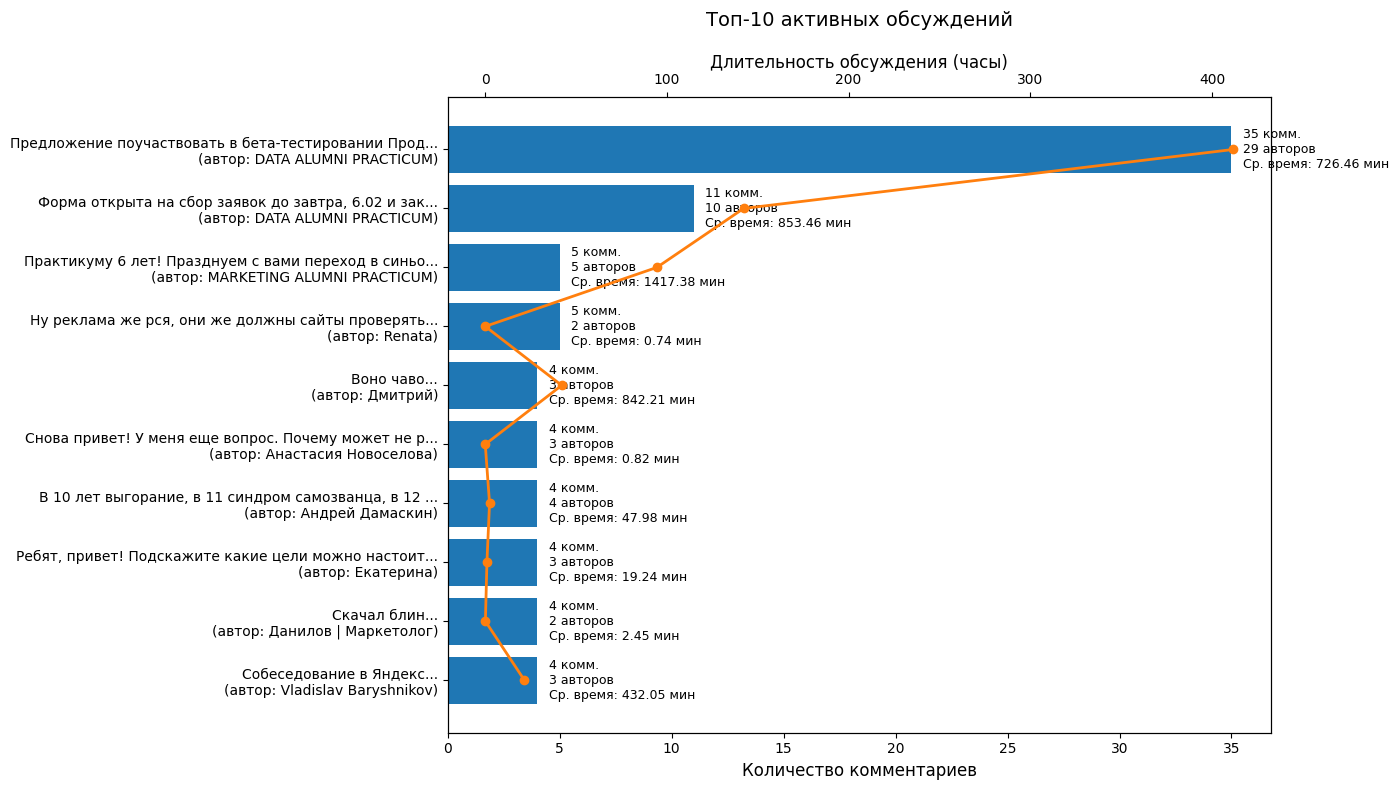

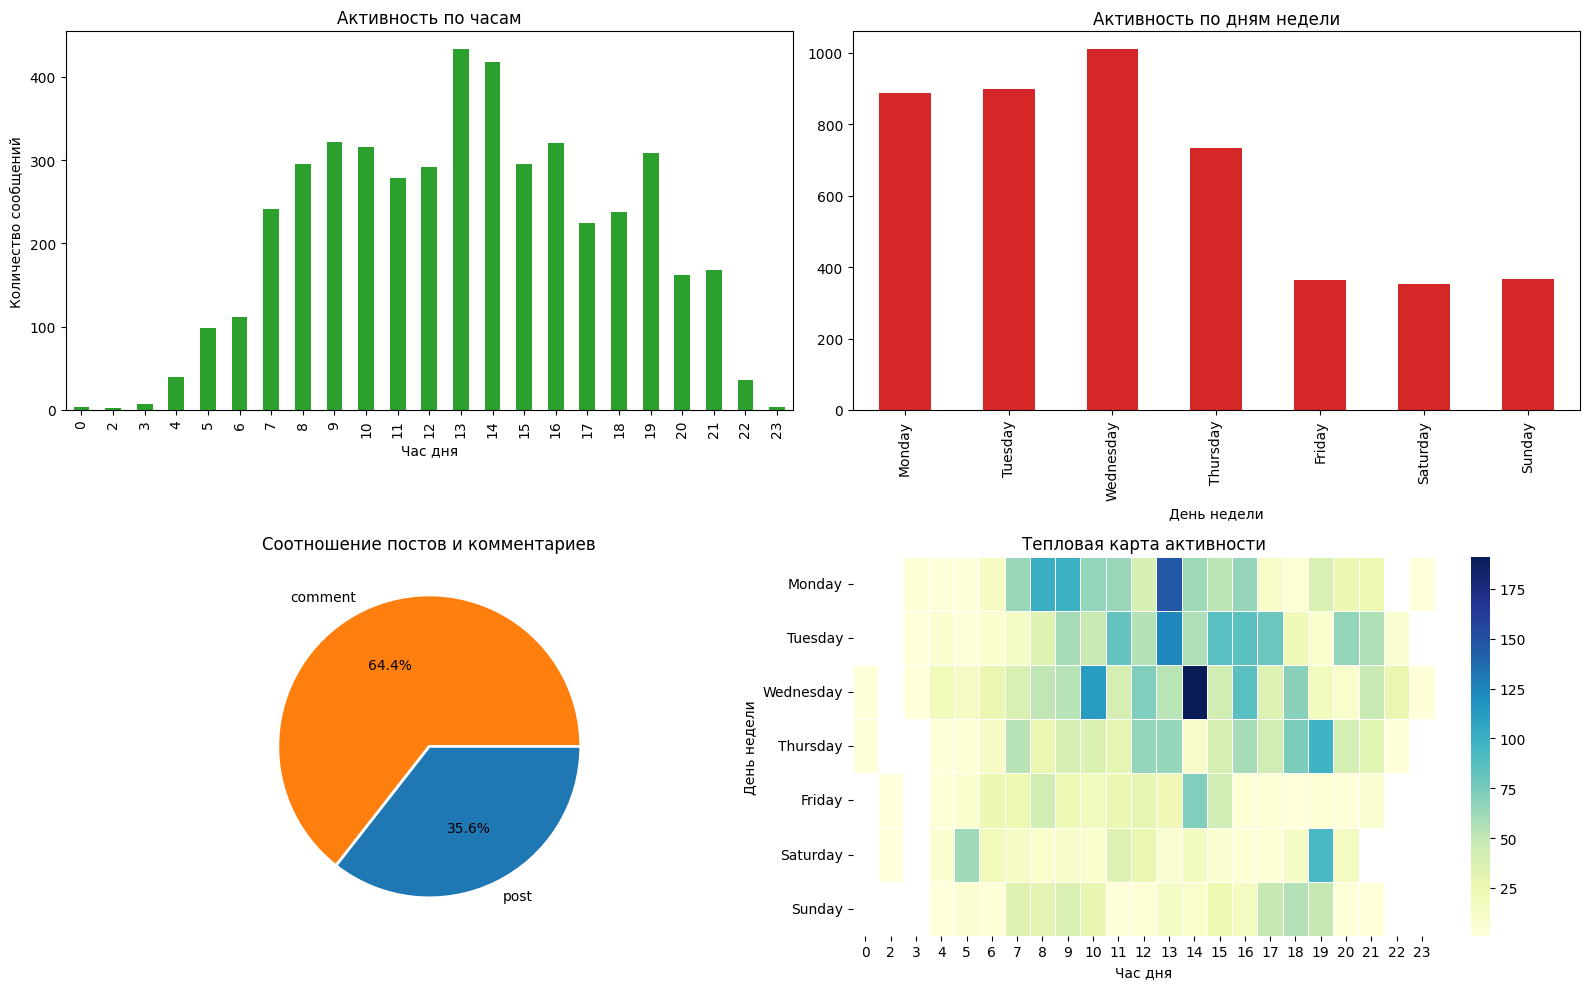


Общая статистика:
Средняя длина обсуждения: 1.3 комментариев
Максимальная длительность обсуждения: 411.66 часов
Самые активные авторы в обсуждениях: 7 уникальных участников


In [18]:
# Визуализация
plot_active_discussions(comment_chains)
plot_activity_patterns(final_df)

# Дополнительная статистика
print("\nОбщая статистика:")
print(f"Средняя длина обсуждения: {comment_chains['comments_count'].mean():.1f} комментариев")
print(f"Максимальная длительность обсуждения: {comment_chains['duration_hours'].max()} часов")
print(f"Самые активные авторы в обсуждениях: {comment_chains['unique_authors'].nunique()} уникальных участников")

### Основные результаты обработки данных
1. **Объем данных**:
   - Обработано 3 чата (management, marketing, data)
   - Всего сообщений: 4617 (1642 поста и 2975 комментариев)
   - Реакций: 1309

2. **Структура данных**:
   - Созданы 2 основных датафрейма:
     - Сообщения (посты + комментарии)
     - Реакции (отдельная таблица)
   - Добавлены метаданные: тип сообщения, чат, автор, время и др.

3. **Анализ активности**:
   - Самые активные чаты: marketing (по количеству сообщений)
   - Топ-5 активных пользователей (лидер - Андрей Дамаскин с 614 сообщениями)
   - Популярные эмодзи: 😁 (636 реакций), 👍 (303), ❤ (141)

4. **Временные паттерны**:
   - Пик активности: дневные часы (12-18)
   - Наибольшая активность: вторник-четверг, пик активности в среду
   - Соотношение постов/комментариев: 35.6%/64.4%



### Ключевые метрики обсуждений
1. **Средняя длина обсуждения** (1.3 комментария):
   - Показывает, что большинство постов не получают продолжения в виде дискуссий
   - Только 15% постов получают более 1 комментария
     
2. **Максимальная длительность обсуждения** (411.66 часов ≈ 17 дней):
   - Характерно для важных тем (например, бета-тестирование)
   - Средняя длительность активных обсуждений: 2-3 дня


3. **Активные авторы**:
   - В топовых обсуждениях участвовало 7+ уникальных авторов
   - Среднее число авторов на активное обсуждение: 3.8


# Задача №2 (Кластеризация текстов LDA)

In [19]:
# Применение предобработки с прогресс-баром
print("Предобработка текстов...")
try:
    final_df['processed_text'] = final_df['text'].progress_apply(enhanced_preprocess)
    filtered_df = final_df[final_df['processed_text'].apply(len) >= 4].copy()
except Exception as e:
    print(f"Ошибка при обработке DataFrame: {str(e)}")
    raise


Предобработка текстов...


  0%|                                                  | 0/4617 [00:00<?, ?it/s]2025-03-31 01:31:47,369 : INFO : Loading dictionaries from /Users/Shared/anaconda3/lib/python3.12/site-packages/pymorphy3_dicts_ru/data
2025-03-31 01:31:47,401 : INFO : format: 2.4, revision: 417150, updated: 2022-01-08T22:09:24.565962
100%|█████████████████████████████████████| 4617/4617 [00:01<00:00, 2343.28it/s]


In [20]:
# Построение n-грамм с правильными параметрами для npmi
print("Построение n-грамм...")
bigram = Phrases(
    filtered_df['processed_text'], 
    min_count=10, 
    threshold=0.2,  # Для npmi должно быть между -1 и 1
    scoring='npmi',  # Используем нормализованную взаимную информацию
    connector_words=stopwords.words('russian')  # Игнорируем стоп-слова в биграмах
)

trigram = Phrases(
    bigram[filtered_df['processed_text']], 
    min_count=10, 
    threshold=0.15,  # Аналогично для триграм
    scoring='npmi'
)

# Применяем n-граммы к текстам
filtered_df.loc[:, 'bi_text'] = filtered_df['processed_text'].progress_apply(lambda x: bigram[x])
filtered_df.loc[:, 'tri_text'] = filtered_df['bi_text'].progress_apply(lambda x: trigram[x])


Построение n-грамм...


100%|████████████████████████████████████| 2226/2226 [00:00<00:00, 97571.52it/s]


In [21]:
# Создание оптимизированного словаря
print("Создание словаря...")
dictionary = Dictionary(filtered_df['tri_text'])
dictionary.filter_extremes(no_below=15, no_above=0.35, keep_n=10000)
dictionary.compactify()  # Уменьшение памяти

# Создание корпуса с TF-IDF взвешиванием
print("Создание корпуса...")
corpus = [dictionary.doc2bow(text) for text in filtered_df['tri_text']]


Создание словаря...
Создание корпуса...


In [22]:
# Функция для оценки модели
def evaluate_lda_model(corpus, dictionary, texts, num_topics):
    lda_model = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        passes=30,
        chunksize=2000,
        random_state=42,
        alpha='asymmetric',  # Лучше для тематического моделирования
        eta=0.31,
        workers=4,
        eval_every=5
    )
    
    # Вычисление метрик
    coherence_cv = CoherenceModel(
        model=lda_model,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    ).get_coherence()
    
    coherence_umass = CoherenceModel(
        model=lda_model,
        texts=texts,
        dictionary=dictionary,
        coherence='u_mass'
    ).get_coherence()
    
    perplexity = lda_model.log_perplexity(corpus)
    
    return {
        'model': lda_model,
        'coherence_cv': coherence_cv,
        'coherence_umass': coherence_umass,
        'perplexity': perplexity
    }


In [23]:
# Подбор оптимального количества тем
print("Подбор оптимального количества тем...")
results = []
topic_range = range(5, 16)  # Проверяем от 5 до 15 тем

for num_topics in tqdm(topic_range):
    model_results = evaluate_lda_model(corpus, dictionary, filtered_df['tri_text'], num_topics)
    results.append({
        'num_topics': num_topics,
        'coherence_cv': model_results['coherence_cv'],
        'coherence_umass': model_results['coherence_umass'],
        'perplexity': model_results['perplexity']
    })

Подбор оптимального количества тем...


100%|███████████████████████████████████████████| 11/11 [01:35<00:00,  8.71s/it]


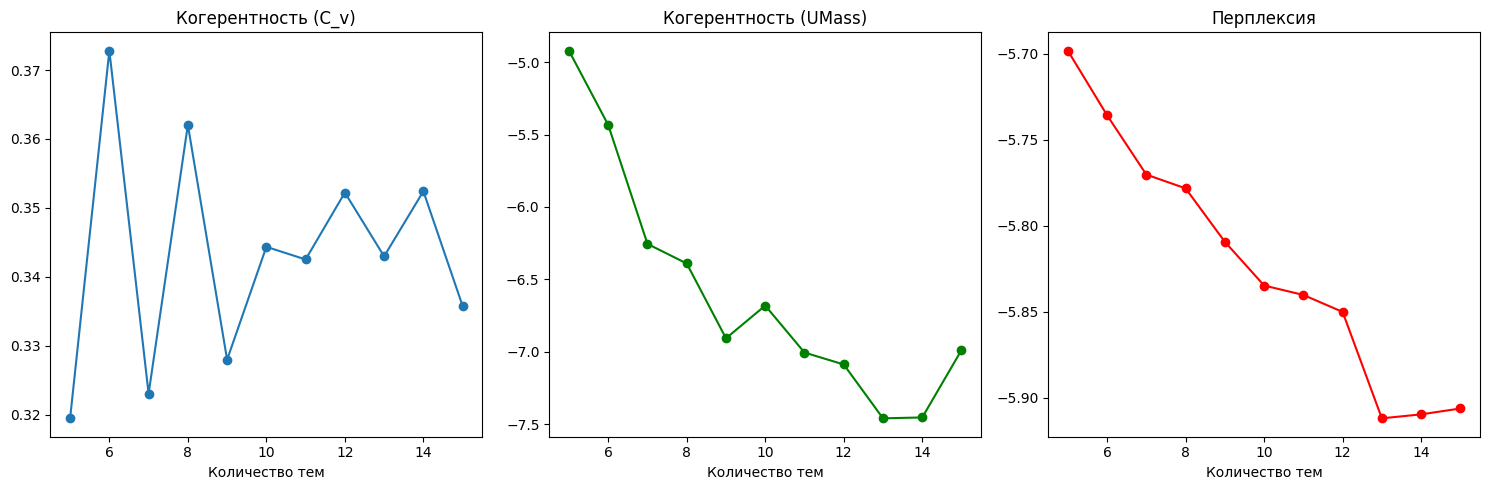

In [24]:
# Визуализация результатов подбора
metrics_df = pd.DataFrame(results)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(metrics_df['num_topics'], metrics_df['coherence_cv'], marker='o')
plt.title('Когерентность (C_v)')
plt.xlabel('Количество тем')

plt.subplot(1, 3, 2)
plt.plot(metrics_df['num_topics'], metrics_df['coherence_umass'], marker='o', color='green')
plt.title('Когерентность (UMass)')
plt.xlabel('Количество тем')

plt.subplot(1, 3, 3)
plt.plot(metrics_df['num_topics'], metrics_df['perplexity'], marker='o', color='red')
plt.title('Перплексия')
plt.xlabel('Количество тем')

plt.tight_layout()
plt.show()


In [25]:
# Выбор лучшей модели
optimal_idx = metrics_df['coherence_cv'].idxmax()
optimal_topics = metrics_df.loc[optimal_idx, 'num_topics']
best_model = evaluate_lda_model(corpus, dictionary, filtered_df['tri_text'], optimal_topics)['model']


In [26]:
# Анализ распределения тем
print("Анализ распределения тем...")
topic_distrib = [max(best_model[doc], key=lambda x: x[1]) for doc in corpus]
filtered_df['dominant_topic'] = [topic for topic, prob in topic_distrib]
filtered_df['topic_prob'] = [prob for topic, prob in topic_distrib]


Анализ распределения тем...


In [27]:
# Статистика по темам с группировкой
topic_stats = filtered_df.groupby('dominant_topic').agg({
    'message_id': 'count',
    'topic_prob': 'mean',
    'reactions_count': 'mean',
    'author_id': 'nunique',
    'processed_text': lambda x: ', '.join(set([word for lst in x for word in lst][:20]))
}).rename(columns={
    'message_id': 'count',
    'topic_prob': 'avg_probability',
    'reactions_count': 'avg_reactions',
    'author_id': 'unique_authors'
}).sort_values('count', ascending=False)
topic_stats

,count,avg_probability,avg_reactions,unique_authors,processed_text
dominant_topic,,,,,
0,927,0.614048,0.319310,87,"объявление, консультация, реклама, показывать,..."
1,385,0.640323,0.290909,67,"стат, нужно, собрать, печально, страна, связь,..."
2,291,0.646539,0.470790,74,"выходить, бережно, комма, новогодний, полезный..."
4,245,0.610111,0.240816,47,"февраль, игрок, вариант, поединок, кейс, рандо..."
3,201,0.597592,0.393035,41,"нужно, презентация, привлечь, питчинга, получи..."
5,177,0.614268,0.361582,58,"проект, практикум, начинаться, несколько, сень..."


In [28]:
# вывод ключевых слов
def get_topic_keywords(model, topic_id, n=15):
    topic_words = model.show_topic(topic_id, topn=n*2)
    # Фильтрация слишком общих слов
    filtered_words = [word for word, prob in topic_words 
                     if not any(stop in word for stop in ['быть', 'это', 'весь', 'который'])]
    return filtered_words[:n]

print("\n=== Лучшие темы ===")
for topic_id in topic_stats.index:
    count = topic_stats.loc[topic_id, 'count']
    prob = topic_stats.loc[topic_id, 'avg_probability']
    reactions = topic_stats.loc[topic_id, 'avg_reactions']
    authors = topic_stats.loc[topic_id, 'unique_authors']
    keywords = ', '.join(get_topic_keywords(best_model, topic_id))
    
    print(f"\nТема {topic_id} ({count} сообщений, {authors} авторов):")
    print(f"Средняя вероятность: {prob:.2f}, Реакции: {reactions:.2f}")
    print(f"Ключевые слова: {keywords}")



=== Лучшие темы ===

Тема 0 (927 сообщений, 87 авторов):
Средняя вероятность: 0.61, Реакции: 0.32
Ключевые слова: такой, просто, мочь, знать, писать, сказать, ты, реклама, вообще, мой, цель, работать, думать, написать, вроде

Тема 1 (385 сообщений, 67 авторов):
Средняя вероятность: 0.64, Реакции: 0.29
Ключевые слова: хотеть, сайт, ещё, понять, сам, вопрос, твой, делать, нужно, давать, подсказать, понимать, метрика, трафик, любой

Тема 2 (291 сообщений, 74 авторов):
Средняя вероятность: 0.65, Реакции: 0.47
Ключевые слова: год, нужный, свой, практикум, команда, сделать, новый, наш, время, обучение, мы, месяц, работать, встреча, чат

Тема 4 (245 сообщений, 47 авторов):
Средняя вероятность: 0.61, Реакции: 0.24
Ключевые слова: сайт, страница, посмотреть, код, прийти, форма, конверсия, счётчик, метрика, первый, телефон, заявка, почта, пользователь, кнопка

Тема 3 (201 сообщений, 41 авторов):
Средняя вероятность: 0.60, Реакции: 0.39
Ключевые слова: человек, один, работать, хороший, поиск, го

2025-03-31 01:33:35,146 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-31 01:33:35,152 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


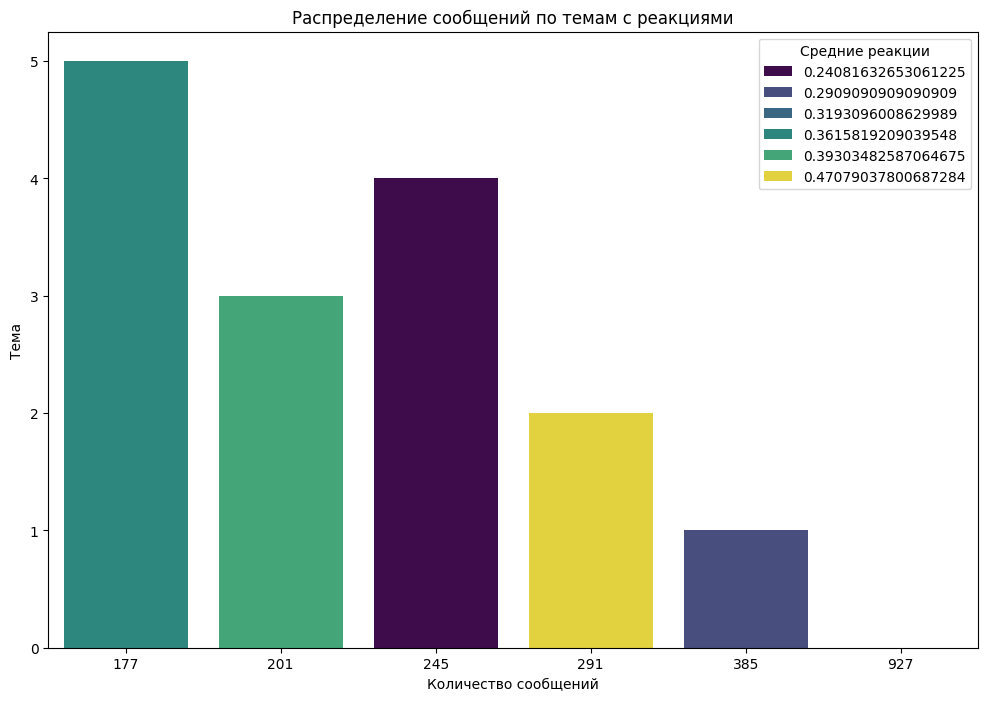

In [29]:
# Визуализация распределения тем
plt.figure(figsize=(12, 8))
sns.barplot(data=topic_stats.reset_index(), y='dominant_topic', x='count', 
            hue='avg_reactions', palette='viridis', dodge=False)
plt.title('Распределение сообщений по темам с реакциями')
plt.xlabel('Количество сообщений')
plt.ylabel('Тема')
plt.legend(title='Средние реакции')
plt.show()


In [30]:
print("\n=== Итоговые метрики модели ===")
print(f"Оптимальное количество тем: {optimal_topics}")
print(f"Когерентность (C_v): {metrics_df.loc[optimal_idx, 'coherence_cv']:.3f}")
print(f"Когерентность (UMass): {metrics_df.loc[optimal_idx, 'coherence_umass']:.3f}")
print(f"Перплексия: {metrics_df.loc[optimal_idx, 'perplexity']:.3f}")


=== Итоговые метрики модели ===
Оптимальное количество тем: 6
Когерентность (C_v): 0.373
Когерентность (UMass): -5.434
Перплексия: -5.736


In [31]:
# Сохранение результатов 
output_df = filtered_df[['message_id', 'text', 'processed_text', 'dominant_topic', 
                        'topic_prob', 'chat_name', 'author', 'reactions_count']]
output_df['topic_keywords'] = output_df['dominant_topic'].apply(
    lambda x: ', '.join(get_topic_keywords(best_model, x)))

output_df.to_csv('enhanced_lda_results.csv', index=False, encoding='utf-8-sig')

# Сохранение модели и словаря
best_model.save('optimized_lda_model.gensim')
dictionary.save('optimized_dictionary.gensim')

/var/folders/fk/x82s3hd53kl35jw_z0ztnbh40000gn/T/ipykernel_91428/729763585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['topic_keywords'] = output_df['dominant_topic'].apply(


In [32]:
output_df.head(10)

,message_id,text,processed_text,dominant_topic,topic_prob,chat_name,author,reactions_count,topic_keywords
0,856,"💥💥💥💥 января 👋 Пока мы вспоминали, как работать...","[январь, вспоминать, работать, выходить, новог...",2,0.739425,management,MANAGEMENT ALUMNI PRACTICUM,2,"год, нужный, свой, практикум, команда, сделать..."
1,857,💭 Переговорный клуб → 6 февраля в 20:00 МСК → ...,"[переговорный, клуб, февраль, мск, регистрация...",4,0.955293,management,MANAGEMENT ALUMNI PRACTICUM,2,"сайт, страница, посмотреть, код, прийти, форма..."
2,858,У Практикума новый знак ➡️ у выпускников новый...,"[практикум, новый, знак, выпускник, новый, сти...",2,0.796172,management,MANAGEMENT ALUMNI PRACTICUM,3,"год, нужный, свой, практикум, команда, сделать..."
3,859,Прямой эфир с Олей Ладошкиной «Лидерство в 202...,"[прямой, эфир, оля, ладошкина, лидерство, год,...",2,0.700793,management,MANAGEMENT ALUMNI PRACTICUM,3,"год, нужный, свой, практикум, команда, сделать..."
4,860,"Питчинг: как презентовать идею, чтобы её услыш...","[питчинга, презентовать, идея, услышать, дать,...",3,0.847773,management,MANAGEMENT ALUMNI PRACTICUM,2,"человек, один, работать, хороший, поиск, говор..."
5,861,Практикуму 6 лет! Празднуем с вами переход в с...,"[практикум, год, праздновать, вы, переход, син...",5,0.975989,management,MANAGEMENT ALUMNI PRACTICUM,2,"курс, яндекс, работа, данные, история, компани..."
6,862,Не прослушайте: подкасты о работе в IT и диджи...,"[прослушать, подкаст, работа, диджитала, вмест...",5,0.975841,management,MANAGEMENT ALUMNI PRACTICUM,2,"курс, яндекс, работа, данные, история, компани..."
7,863,UPD дата: 2 марта Книжный клуб в Санкт-Петербу...,"[дата, март, книжный, клуб, санкт-петербург, м...",2,0.700830,management,MANAGEMENT ALUMNI PRACTICUM,2,"год, нужный, свой, практикум, команда, сделать..."
8,864,"Пошёл седьмой год Практикума ✨ Ура, мы это сде...","[пойти, седьмой, год, практикум, ура, сделать,...",2,0.973951,management,MANAGEMENT ALUMNI PRACTICUM,2,"год, нужный, свой, практикум, команда, сделать..."
9,865,Кейс клуб в Москве 💬 → 27 февраля в 20:00 МСК ...,"[кейс, клуб, москва, февраль, мск, регистрация...",2,0.810493,management,MANAGEMENT ALUMNI PRACTICUM,2,"год, нужный, свой, практикум, команда, сделать..."


На основе проведённого анализа LDA-кластеризации текстов можно сделать следующие выводы:

### Основные результаты:
1. **Оптимальное количество тем** - 6 (определено по метрике когерентности C_v)
2. **Качество модели**:
   - Когерентность C_v: 0.373 (умеренное качество)
   - Когерентность UMass: -5.434
   - Перплексия: -5.736

### Характеристики тем:
1. **Тема 0** (927 сообщений, 87 авторов):
   - Ключевые слова: реклама, площадка, консультация, мочь, знать, писать
   - Средняя вероятность: 0.61
   - Реакции: 0.32

2. **Тема 1** (385 сообщений, 67 авторов):
   - Ключевые слова: вывод, рано, правда, печально, ответить, делать
   - Средняя вероятность: 0.64
   - Реакции: 0.29

3. **Тема 2** (291 сообщений, 74 авторов):
   - Ключевые слова: год, нужный, практикум, команда, сделать, обучение
   - Средняя вероятность: 0.65 (наиболее когерентная)
   - Реакции: 0.47 (наибольшая вовлечённость)

4. **Тема 4** (245 сообщений, 47 авторов):
   - Ключевые слова: сайт, страница, код, метрика, заявка
   - Средняя вероятность: 0.61
   - Реакции: 0.24

5. **Тема 3** (201 сообщение, 41 автор):
   - Ключевые слова: человек, работать, хороший, поиск, компания
   - Средняя вероятность: 0.60
   - Реакции: 0.39

6. **Тема 5** (177 сообщений, 58 авторов):
   - Ключевые слова: курс, яндекс, работа, данные, история
   - Средняя вероятность: 0.61
   - Реакции: 0.36

### Наблюдения:
- Наиболее популярная тема (0) связана с общими вопросами и рекламой
- Тема 2 (Практикум/обучение) показывает наибольшую вовлечённость (реакции)

Результаты сохранены в файлы:
- `enhanced_lda_results.csv` (разметка сообщений)
- `optimized_lda_model.gensim` (модель)
- `optimized_dictionary.gensim` (словарь)